# Decision Tree Method : EMU-Fight

This notebook shows the emulation of the two point correlation functions using Decision Tree.

Decision tree builds regression or classification models in the form of a tree structure which are among the most popular machine learning algorithms given their intelligibility and simplicity.

For more information: https://www.saedsayad.com/decision_tree_reg.htm

#### Index<a name="index"></a>
1. [Import packages](#imports)
* [Load data](#loadData)
 1. [Load train data](#loadTrainData)
 * [Load test data](#loadTestData)
1. [Visualiazing the dataset](#visualization)
* [Emulator method](#emulator)

## 1. Import packages<a name="imports"></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

## 2. Load data<a name="loadData"></a>

Read the training data from a `.npy` file:

### 2.1. Load train data<a name="loadTrainData"></a>

In [3]:
import pandas as pd

df = pd.read_pickle('../data/cosmology_train_big.pickle')

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values $r$.

### 2.2. Load test data<a name="loadTestData"></a>

In [4]:
df_test = pd.read_pickle('../data/cosmology_test.pickle')

## 3. Visualiazing the dataset<a name="visualization"></a>

#### 3.1 Data Structure: Pickle, Pandas DataFrame

The cosmology dataset contains cosmological parameters (Omega_m, sigma8, Omega_b) as inputs, and the correlation function as output. The correlation function is measured at 10 separation values  𝑟 .

In [5]:
df_in = df['input_data']
df_in

,object_id,$\Omega_m$,$\sigma_8$,$\Omega_b$
0,obj_0,0.26,0.70,0.038000
1,obj_1,0.26,0.70,0.039053
2,obj_2,0.26,0.70,0.040105
3,obj_3,0.26,0.70,0.041158
4,obj_4,0.26,0.70,0.042211
...,...,...,...,...
7995,obj_7995,0.34,0.95,0.053789
7996,obj_7996,0.34,0.95,0.054842
7997,obj_7997,0.34,0.95,0.055895
7998,obj_7998,0.34,0.95,0.056947


In [6]:
df_out = df['output_data']
df_out

,object_id,$\xi(r_0)$,$\xi(r_1)$,$\xi(r_2)$,$\xi(r_3)$,$\xi(r_4)$,$\xi(r_5)$,$\xi(r_6)$,$\xi(r_7)$,$\xi(r_8)$,$\xi(r_9)$
0,obj_0,0.007281,0.003812,0.002051,0.001160,0.000831,0.001003,0.001137,0.000513,-0.000027,-0.000187
1,obj_1,0.007404,0.003890,0.002103,0.001199,0.000873,0.001070,0.001194,0.000514,-0.000035,-0.000192
2,obj_2,0.007528,0.003970,0.002157,0.001239,0.000916,0.001139,0.001250,0.000514,-0.000044,-0.000196
3,obj_3,0.007656,0.004052,0.002211,0.001280,0.000962,0.001211,0.001305,0.000512,-0.000053,-0.000201
4,obj_4,0.007785,0.004135,0.002267,0.001323,0.001009,0.001287,0.001360,0.000509,-0.000061,-0.000205
...,...,...,...,...,...,...,...,...,...,...,...
7995,obj_7995,0.008040,0.003810,0.001858,0.001105,0.001628,0.001964,0.000209,-0.000452,-0.000460,-0.000390
7996,obj_7996,0.008179,0.003896,0.001916,0.001158,0.001728,0.002018,0.000186,-0.000461,-0.000464,-0.000394
7997,obj_7997,0.008321,0.003984,0.001975,0.001214,0.001833,0.002068,0.000162,-0.000470,-0.000468,-0.000398
7998,obj_7998,0.008465,0.004074,0.002035,0.001271,0.001942,0.002115,0.000139,-0.000479,-0.000471,-0.000403


In [7]:
rvals = df['extra_input']['r_vals']
rvals

array([ 50.,  60.,  70.,  80.,  90., 100., 110., 120., 130., 140.])

#### 3.3 Defining variables

In [8]:
df_out.columns

Index(['object_id', '$\xi(r_0)$', '$\xi(r_1)$', '$\xi(r_2)$', '$\xi(r_3)$',
       '$\xi(r_4)$', '$\xi(r_5)$', '$\xi(r_6)$', '$\xi(r_7)$', '$\xi(r_8)$',
       '$\xi(r_9)$'],
      dtype='object')

In [9]:
df_in.columns

Index(['object_id', '$\Omega_m$', '$\sigma_8$', '$\Omega_b$'], dtype='object')

In [10]:
ys_train = df_out[[r'$\xi(r_0)$', r'$\xi(r_1)$', r'$\xi(r_2)$', r'$\xi(r_3)$',
       r'$\xi(r_4)$', r'$\xi(r_5)$', r'$\xi(r_6)$', r'$\xi(r_7)$', r'$\xi(r_8)$',
       r'$\xi(r_9)$']].to_numpy()

xs_train = df_in[[r'$\Omega_m$', r'$\sigma_8$', r'$\Omega_b$']].to_numpy()
# xs_train = df_in[[r'$\Omega_m$']].to_numpy()

In [11]:
print('x shape:',xs_train.shape)
print('y shape:',ys_train.shape)

x shape: (8000, 3)
y shape: (8000, 10)


#### 3.3 Visualizing the dataset

Text(0, 0.5, '$\\xi(r)$')

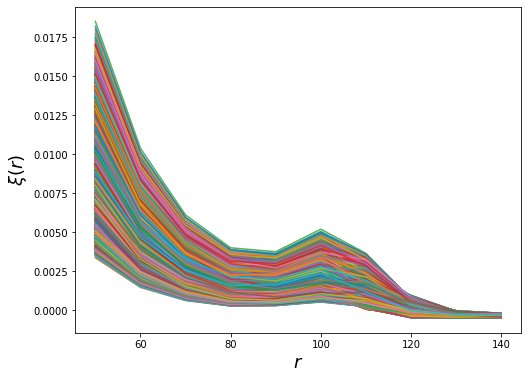

In [12]:
plt.figure(figsize=(8,6))
ys_train_plot = ys_train.copy()
np.random.shuffle(ys_train_plot) # shuffle so that color order isn't weird
plt.plot(rvals, ys_train_plot.T, alpha=0.8)

plt.xlabel('$r$',fontsize=18)
plt.ylabel(r'$\xi(r)$',fontsize=18)

# plt.xscale('log')
# plt.yscale('log')


Let's do the same for our test set:

In [13]:
df_test_in = df_test['input_data']
df_test_out = df_test['output_data']

ys_test = df_test_out[[r'$\xi(r_0)$', r'$\xi(r_1)$', r'$\xi(r_2)$', r'$\xi(r_3)$',
       r'$\xi(r_4)$', r'$\xi(r_5)$', r'$\xi(r_6)$', r'$\xi(r_7)$', r'$\xi(r_8)$',
       r'$\xi(r_9)$']].to_numpy()

xs_test = df_test_in[[r'$\Omega_m$', r'$\sigma_8$', r'$\Omega_b$']].to_numpy()

In [14]:
n_test = xs_test.shape[0]
n_values= ys_test.shape[1]
n_params= xs_test.shape[1]
print("Number of datapoints:", n_test)
print("Number of input parameters:", n_params)
print("Number of output values:", n_values)

Number of datapoints: 100
Number of input parameters: 3
Number of output values: 10


Text(0, 0.5, '$\\xi(r)$')

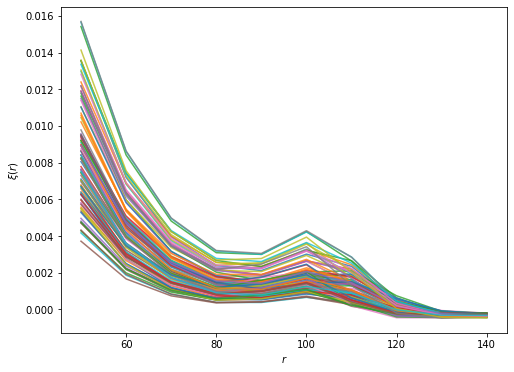

In [15]:
plt.figure(figsize=(8,6))
plt.plot(rvals, ys_test.T, alpha=0.8)
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')

## 4. Emulator method<a name="emulator"></a>

SVM Method

based on this example: https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html#sphx-glr-auto-examples-svm-plot-svm-regression-py

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor


# #############################################################################
# sample data
y_mean = np.mean(ys_train,axis=0)
ys_train/= y_mean
ys_test /= y_mean

scaler = StandardScaler()
scaler.fit(xs_train)
xs_train = scaler.transform(xs_train)
xs_test = scaler.transform(xs_test)

In [33]:
def do_regresssion():
    regrs = np.empty(n_values, dtype=object)
    scores= np.empty(n_values, dtype=object)
    for j in range(n_values):
        ys_train_r = ys_train[:,j]
        ys_test_r = ys_test[:,j]
        
        ## mae: median absolute error
        ## works better than mse(mean square error)
        regr = DecisionTreeRegressor(random_state=0, criterion="mae").fit(xs_train, ys_train_r)
        score = regr.score(xs_test, ys_test_r)
        print(f"Value {j} score:", score)
        regrs[j] = regr
        scores[j] = score
    print()
    return regrs, scores

In [34]:
from sklearn.ensemble import GradientBoostingRegressor

def do_regresssion2():
    regrs = np.empty(n_values, dtype=object)
    scores= np.empty(n_values, dtype=object)
    for j in range(n_values):
        ys_train_r = ys_train[:,j]
        ys_test_r = ys_test[:,j]
        
        ## mae: median absolute error
        ## works better than mse(mean square error)
        regr = GradientBoostingRegressor(criterion="mae", random_state=42).fit(xs_train, ys_train_r)
        score = regr.score(xs_test, ys_test_r)
        print(f"Value {j} score:", score)
        regrs[j] = regr
        scores[j] = score
    print()
    return regrs, scores

In [35]:
r,s = do_regresssion()

Value 0 score: 0.9971436032079883
Value 1 score: 0.9971004178969757
Value 2 score: 0.9970640283886528
Value 3 score: 0.9970475230600824
Value 4 score: 0.9971023906207966
Value 5 score: 0.9973276642394178
Value 6 score: 0.9969460159910037
Value 7 score: 0.9962982070270494
Value 8 score: 0.9968210393283217
Value 9 score: 0.9977855670523595



In [36]:
# r,s = do_regresssion2()

#### 3.3 Grid Params

In [37]:
regrs = r

In [38]:
ys_predict = np.zeros((n_test, n_values))
for j in range(n_values):  
    ys_predict_r = regrs[j].predict(xs_test)
    ys_predict[:,j] = ys_predict_r

In [39]:
n_plot = int(0.2*n_test)
idxs = np.random.choice(np.arange(n_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

In [40]:
ys_train = ys_train*y_mean
ys_test = ys_test*y_mean
ys_predict = ys_predict*y_mean

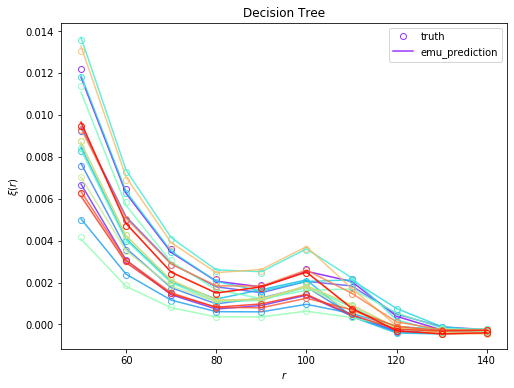

In [41]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    if i==0:
        label_test = 'truth'
        label_predict = 'emu_prediction'
    else:
        label_test = None
        label_predict = None
    plt.plot(rvals[:n_values], ys_test_plot, alpha=0.8, label=label_test, marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(rvals[:n_values], ys_predict_plot, alpha=0.8, label=label_predict, color=colors[i])
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')
plt.title('Decision Tree')
plt.legend()

Text(0, 0.5, 'fractional error')

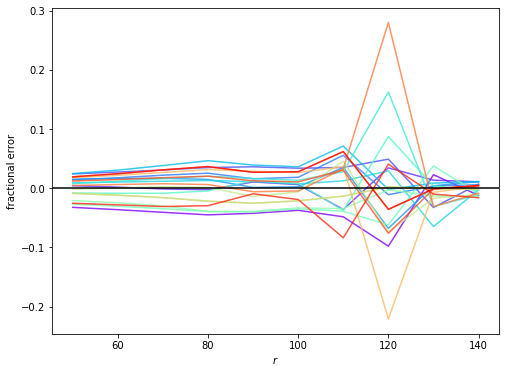

In [42]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    frac_err = (ys_predict_plot-ys_test_plot)/ys_test_plot
    plt.plot(rvals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')

In [43]:
DecisionTreeRegressor()

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [48]:
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

scoring = make_scorer(r2_score)
param_grid = [{'criterion':['mse','mae'], 'max_depth': range(2, 10)}]

print("Best parameters set found on development set:")
for ix in range(n_values):
    g_cv = GridSearchCV(DecisionTreeRegressor(random_state=0), param_grid, scoring=scoring, refit=True, cv=10)
    g_cv.fit(xs_train, ys_train[:,ix])
    score = r2_score(ys_test[:,ix], g_cv.predict(xs_test))
    print()
    print('radii bin %i'%ix)
    print('%.4f'%score,':',g_cv.best_params_)
    print()

Best parameters set found on development set:

radii bin 0
0.9827 : {'criterion': 'mae', 'max_depth': 9}


radii bin 1
0.9875 : {'criterion': 'mae', 'max_depth': 9}


radii bin 2
0.9893 : {'criterion': 'mae', 'max_depth': 9}


radii bin 3
0.9844 : {'criterion': 'mae', 'max_depth': 9}


radii bin 4
0.9838 : {'criterion': 'mae', 'max_depth': 9}


radii bin 5
0.9874 : {'criterion': 'mae', 'max_depth': 9}


radii bin 6
0.9914 : {'criterion': 'mae', 'max_depth': 9}


radii bin 7
0.9937 : {'criterion': 'mae', 'max_depth': 9}


radii bin 8
0.9876 : {'criterion': 'mae', 'max_depth': 9}


radii bin 9
0.9913 : {'criterion': 'mae', 'max_depth': 9}

